# Constructing quantum circuits in QuAIRKit

A quantum circuit is a series of operations, including quantum gates, initializations of qubits to known values, measurements, that act on qubits to perform a quantum algorithm.
Circuits are written such that the horizontal axis is time, starting at the left-hand side and ending at the right. Horizontal lines are qubits, and doubled lines represent classical bits. The items that are connected by these lines are operations performed on the qubits, such as measurements or gates. These lines define the sequence of events and are usually not physical cables
QuAIRKit uses the `Circuit` class to represent quantum circuits. In this tutorial, we will learn how to manipulate quantum circuits in QuAIRKit.

**Table of contents**

- [Constructing quantum circuits](#Constructing-quantum-circuits)
  - [Add operations](#Add-operations)
  - [Add custom gates](#Add-custom-gates)
  - [Add quantum channels](#Add-quantum-channels)
  - [Add custom quantum channels](#Add-custom-quantum-channels)
  - [Add circuit templates](#Add-circuit-templates)
  - [Operator management](#Operator-management)
  - [Circuit Execution](#Circuit-execution)
- [Other properties](#Other-properties)

In [1]:
import numpy as np
import torch

import quairkit as qkit
from quairkit import Circuit
from quairkit.database import *
from quairkit.operator import RZ, ChoiRepr, KrausRepr, StinespringRepr, Oracle
from quairkit.qinfo import *

## Constructing quantum circuits

In QuAIRKit, circuits can be generated with or without specifying the total number of qubits.

In [2]:
num_qubits = 3  # number of qubits
cir = Circuit(num_qubits)  # construct a circuit with specifying the number of qubits

### Add operations

Fixed gates can be directly called from the attributes of the `Circuit` class. The semantic rule for specifying the locations added operations is as follows:

- No inputs: The operations are added across all qubits.
- `int`: The single-qubit operation is added to the specified qubit.
- `List[int]`: The single-qubit operation is added across the specified qubits, or the multi-qubit operation is added across the specified qubits.
- `List[List[int]]`: The multi-qubit operation is added across different groups of specified qubits.

the diagram of a quantum circuit:


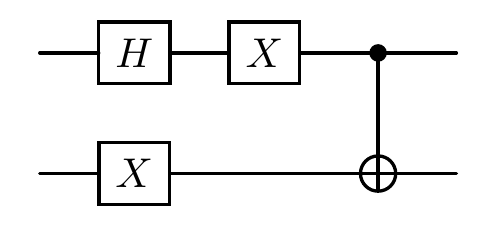

the total number of qubit of the circuit is 3


In [3]:
cir.h(0)  # Add Hadamard gate to qubit 0
cir.x([0, 1])  # Add X gate to qubit 0 and 1
cir.cx([0, 1])  # Add CNOT gate to qubit 0 and 1
print("the diagram of a quantum circuit:")
cir.plot()
print(f"the total number of qubit of the circuit is {cir.num_qubits}")

As the quantum circuit (with the initialization and measurement stages omitted) just represents a unitary evolution, we can express the whole things a matrix. We must follows the following rules:
- Composition across wires is achieved by the tensor product.
- Composition along (sets of) wires is achieved by the normal matrix product, but **right to left**.

For example, the circuit we just constructed is equal to
$$
U = \text{CNOT} \times (X\otimes X) \times (H \otimes I_{2}) = \frac{1}{\sqrt{2}}
\begin{bmatrix}
0&1&0&-1 \\
1&0&-1&0 \\
1&0&1&0 \\
0&1&0&1
\end{bmatrix},
$$
where $I_{2}$ is the $2\times 2$ identity.
We can verify this equality by `Circuit.matrix`.

In [4]:
print(f"the unitary matrix of the circuit:\n{cir.matrix}")

the unitary matrix of the circuit:
tensor([[ 0.0000+0.j,  0.0000+0.j,  0.7071+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,
         -0.7071+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.7071+0.j,  0.0000+0.j,  0.0000+0.j,
          0.0000+0.j, -0.7071+0.j],
        [ 0.7071+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j, -0.7071+0.j,  0.0000+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.7071+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j, -0.7071+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.7071+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.7071+0.j,  0.0000+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.7071+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.7071+0.j,
          0.0000+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j,  0.7071+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j,
          0.7071+0.j,  0.0000+0.j],
        [ 0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.7071+0.j,  0.0000+0.j,  0.0000+0.j,
          0.0000+

We can add more different types of gates, and change the total number of qubits of the circuit.

the diagram of the quantum circuit with more gates:


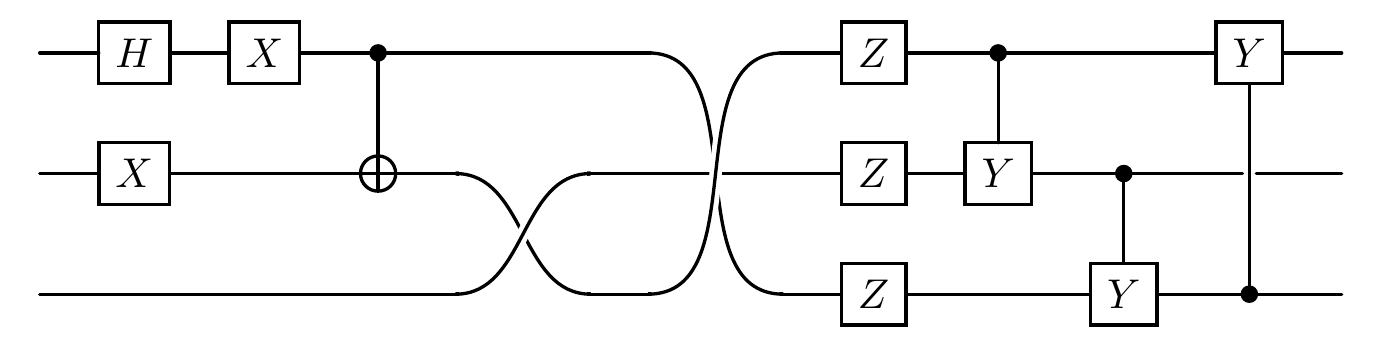

the total number of qubit of the circuit is 3


In [5]:
cir.swap([[1, 2], [0, 2]])  # Add SWAP gate to qubit 1 and 2, and qubit 0 and 2
cir.z()  # Add Z gate to all qubits
cir.cy()  # Add CY gate in cycle
print("the diagram of the quantum circuit with more gates:")
cir.plot()
print(f"the total number of qubit of the circuit is {cir.num_qubits}")

When the number of qubits is not specified, the total number of qubits will be changed as operations are added to the circuit.

For parametrized gates, `Circuit` can add the gate with randomly generated parameters, or you can specify them as keyword arguments.

the diagram of a quantum circuit with parametrized gates:


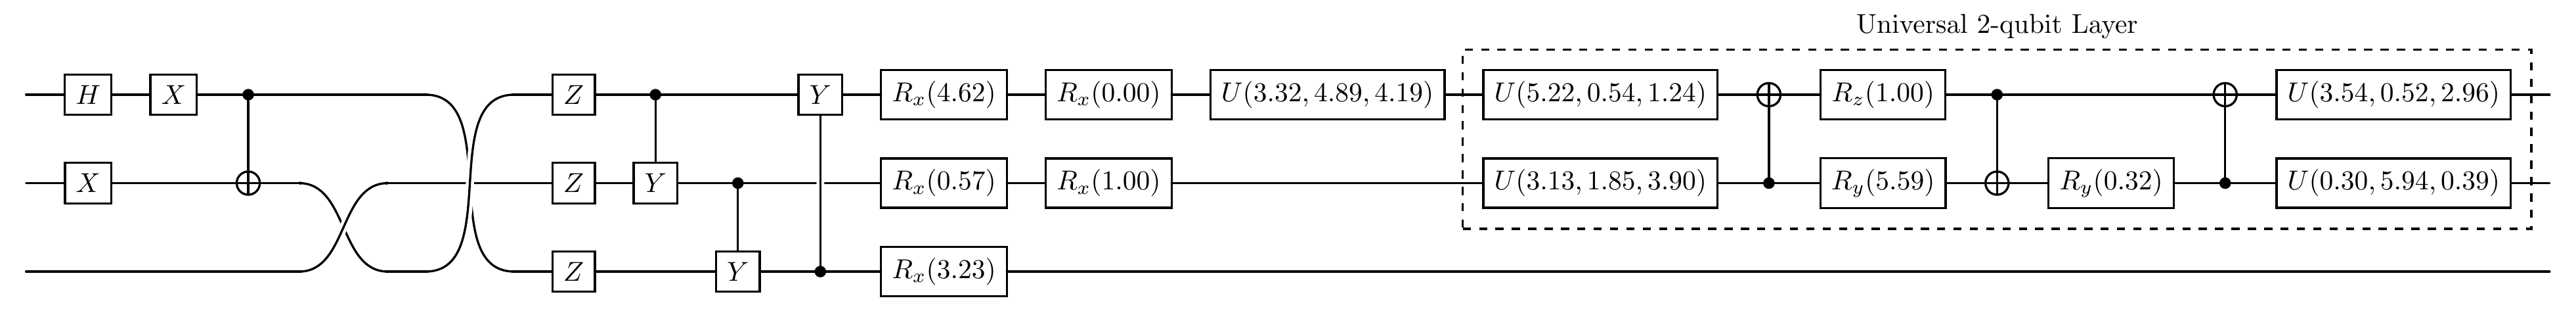

In [6]:
cir.rx() # Add Rx gate to all qubits with random parameters
cir.rx([0, 1], param=np.arange(2)) # Add RX gate to the first two qubits with specified parameters

cir.u3([0]) # Add universal single qubit gate
cir.universal_two_qubits([0, 1]) # Add universal two qubits gate
# cir.universal_three_qubits([0, 1, 2]) # Add universal three qubits gate

print("the diagram of a quantum circuit with parametrized gates:")
cir.plot()

### Add custom gates

We have shown how to insert a gate into a `Circuit`. Moreover, one can add custom gates by specifying the matrix representation of the gate. This can be done through `Circuit.oracle`.

For instance, consider the $n$-qubit inverse quantum Fourier transformation (QFT). It is a unitary operation whose matrix is given by
$$
\text{QFT}^{\dagger}=\frac{1}{\sqrt{N}}
\begin{bmatrix}
1&1&1&\dots&1\\
1&\omega^{N-1}&\omega^{N-2}&\dots&\omega\\
1&\omega^{2(N-1)}&\omega^{2(N-2)}&\dots&\omega^{2}\\
\vdots&\vdots&\vdots&\dots&\vdots\\
1&\omega^{(N-1)(N-1)}&\omega^{(N-1)(N-2)}&\dots&\omega^{N-1}\\
\end{bmatrix},
$$
where $N=2^{n}$ is the dimension of the Hilbert space and $\omega=e^{2\pi i/N}$.

the diagram of a quantum circuit with a custom gate:


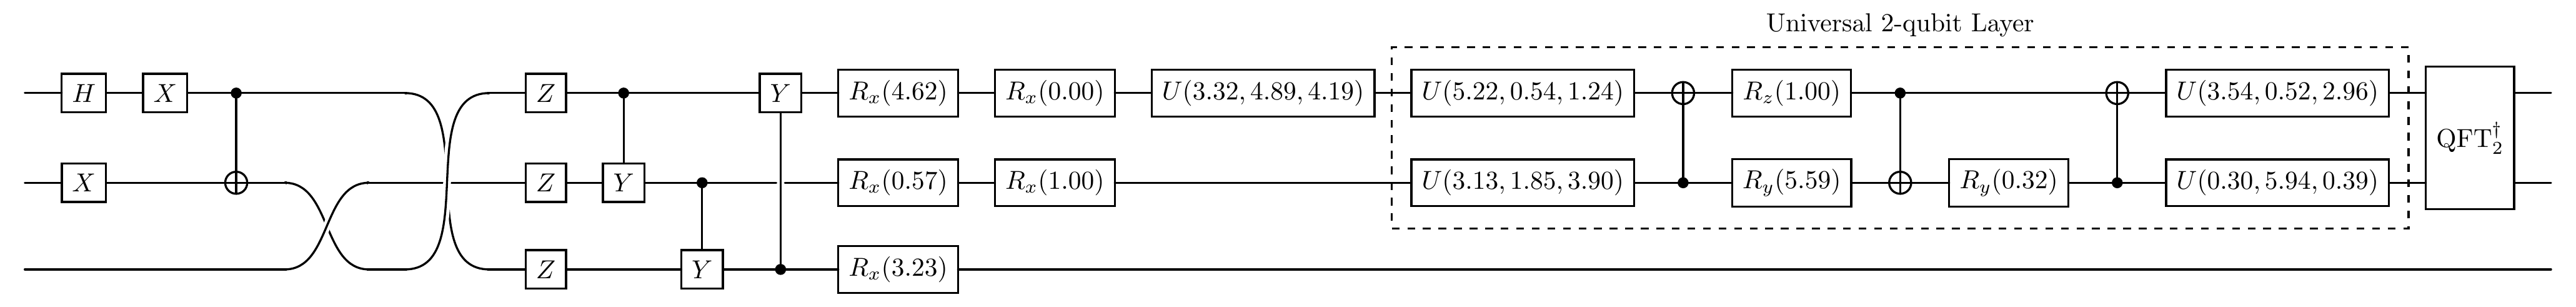

In [7]:
qft_mat = qft_matrix(num_qubits=2)  # construct a 2-qubit quantum Fourier transformation (QFT) operator
qft_inverse = dagger(qft_mat)  # get the inverse QFT

cir.oracle(qft_inverse, qubits_idx=[0, 1], latex_name=r'\text{QFT}_{2}^{\dagger}')  # add custom gate

print("the diagram of a quantum circuit with a custom gate:")
cir.plot()

Users can also implement custom gates using `Circuit.append`.

the diagram of a quantum circuit with custom gates:


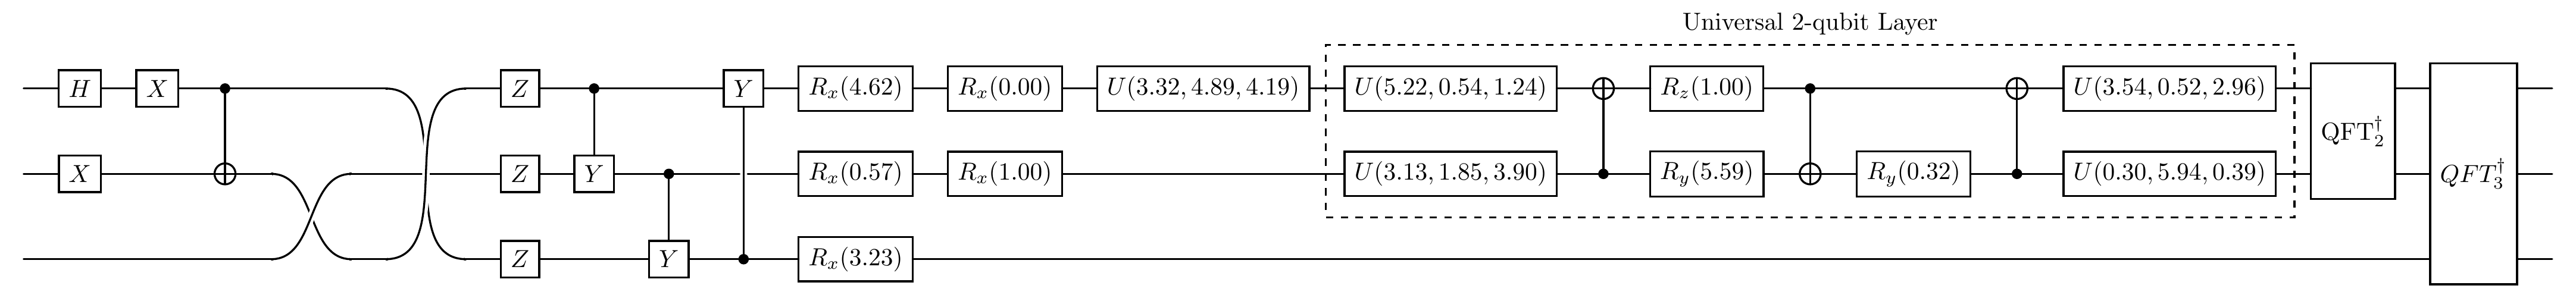

In [8]:
qft_mat = qft_matrix(num_qubits=3)  # construct a 3-qubit quantum Fourier transformation (QFT) operator
qft_inverse = dagger(qft_mat)  # get the inverse QFT
custom_unitary = Oracle(qft_inverse, system_idx=list(range(3)), gate_info={"tex": r'QFT_{3}^{\dagger}'})

cir.append(custom_unitary)

print("the diagram of a quantum circuit with custom gates:")
cir.plot()

Furthermore, in QuAIRKit, adding a controlled custom gate is supported.

the diagram of a quantum circuit with a controlled custom gate:


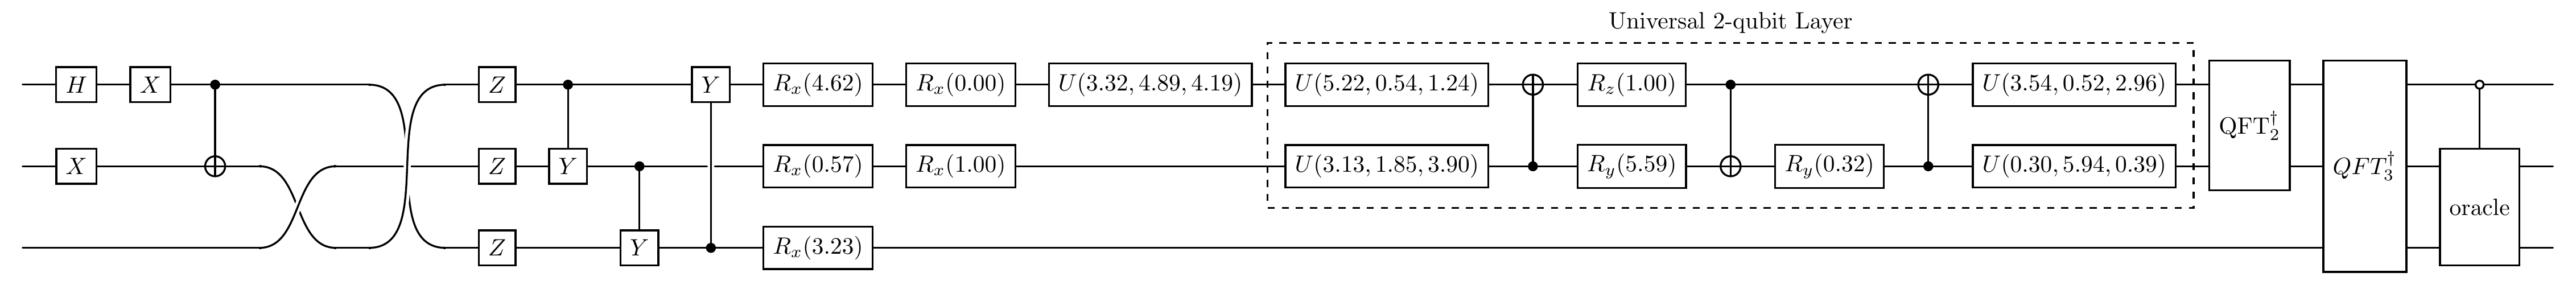

In [9]:
cir.oracle(random_unitary(num_qubits=2), qubits_idx=[0, 1, 2], control_idx=0, gate_name="O")

print("the diagram of a quantum circuit with a controlled custom gate:")
cir.plot()

### Add quantum channels

Similar construction semantic applies to quantum channels such as depolarizing channel, bit-phase flip channel and so on. However, the related plot logic is not supported yet.

In [10]:
cir.depolarizing(prob=0.1, qubits_idx=[0])  # add a depolarizing channel (with probability 0.1) to qubit 0
cir.bit_phase_flip(0.2)  # Add bit-phase flip channels (with probability 0.2) to all qubits

### Add custom quantum channels 

One can also add a custom quantum channel to a `Circuit`, where the quantum channel can be in Choi, Kraus, or Stinespring representations. We show how to add a custom channel using these three different representations.

In [11]:
rho = random_state(num_qubits=3)
replacement_choi_repr = replacement_choi(rho)  # replacement channel in Choi representation
cir.choi_channel(replacement_choi_repr, system_idx=[0, 1, 2])  # add replacement channel in Choi representation

reset_kraus_repr = reset_kraus([0.1, 0.2])  # reset channel in Kraus representation
cir.kraus_channel(reset_kraus_repr, system_idx=2)  # add reset channel in Kraus representation

random_stin_repr = random_channel(num_systems=1, target="stinespring")  # random single-qubit channel in Stinespring representation
cir.stinespring_channel(random_stin_repr, system_idx=1)  # add random channel in Stinespring representation

Similarly, you can implement custom channels using `Circuit.append`.

In [12]:
choi_op = random_channel(num_systems=2, target="choi")
choi_repr = ChoiRepr(choi_op, system_idx=[1, 2])
cir.append(choi_repr)

kraus_op = random_channel(num_systems=1, target="kraus")
kraus_repr = KrausRepr(kraus_op, system_idx=0)
cir.append(kraus_repr)

stine_op = random_channel(num_systems=3, target="stinespring")
stine_repr = StinespringRepr(stine_op, system_idx=[0, 1, 2])
cir.append(stine_repr)

Circuit(
  (0): H()
  (1): X()
  (2): CNOT()
  (3): SWAP()
  (4): Z()
  (5): CY()
  (6): RX()
  (7): RX()
  (8): U3()
  (9): Universal2(
    (0): U3()
    (1): CNOT()
    (2): RZ()
    (3): RY()
    (4): CNOT()
    (5): RY()
    (6): CNOT()
    (7): U3()
  )
  (10): Oracle()
  (11): Oracle()
  (12): ControlOracle()
  (13): Depolarizing()
  (14): BitPhaseFlip()
  (15): ChoiRepr()
  (16): KrausRepr()
  (17): StinespringRepr()
  (18): ChoiRepr()
  (19): KrausRepr()
  (20): StinespringRepr()
)

More available operations can be found in the [API document](https://www.quairkit.com).

### Add circuit templates

QuAIRKit provides predefined circuit templates, or ansatz consisting of a sequence of gates applied to qubits. Note that the templates are only available for the circuits with a known number of qubits.

the diagram of a quantum circuit with different kinds of layers:


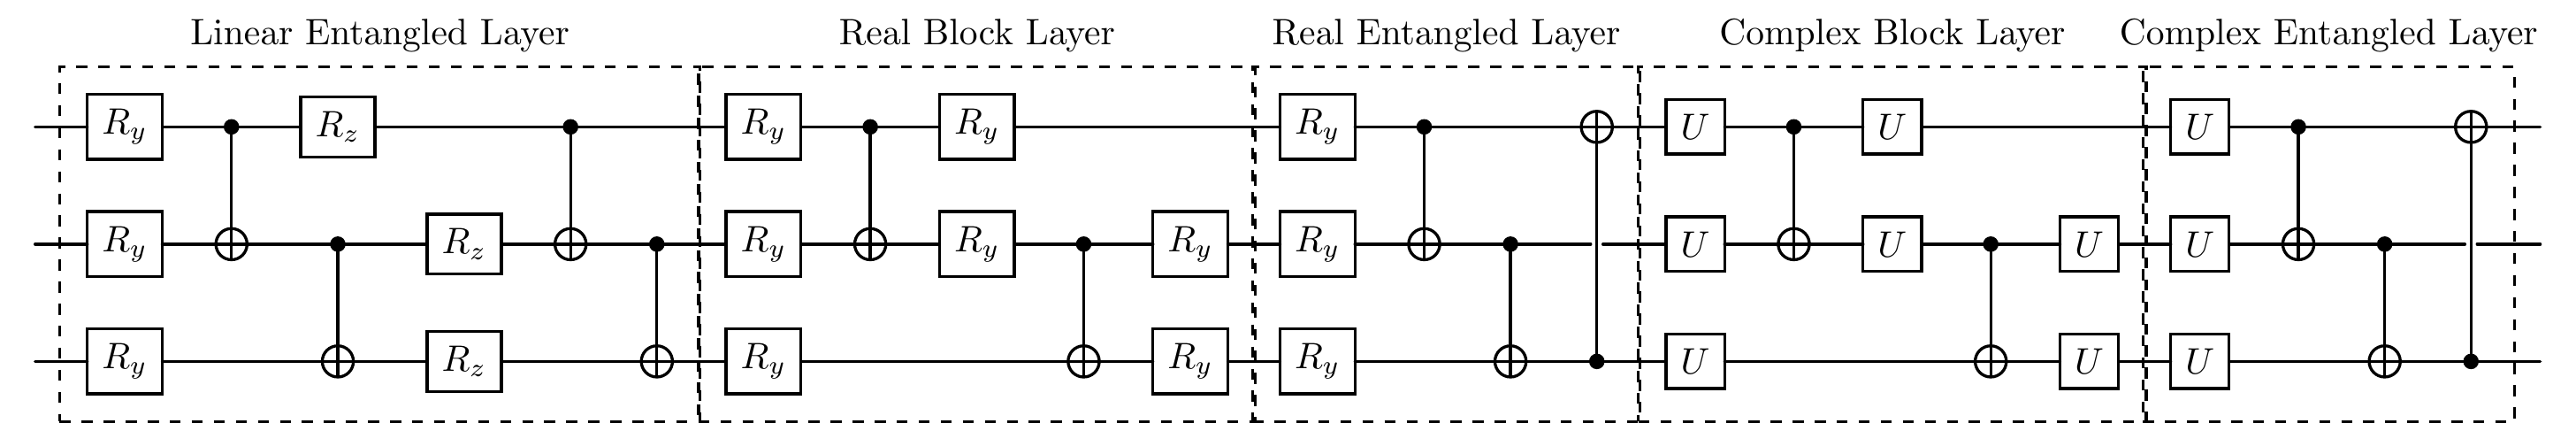

In [13]:
num_qubits = 3  # number of qubits
cir = Circuit(num_qubits)

cir.linear_entangled_layer(depth=1)  # add a linear entangled layer

cir.real_block_layer(depth=1)  # add real block layers in depth 2
cir.real_entangled_layer(depth=1)  # add a real entangled layer

cir.complex_block_layer(depth=1)  # add a complex block layer 
cir.complex_entangled_layer(depth=1)  # add a complex entangled layer

print("the diagram of a quantum circuit with different kinds of layers:")
cir.plot(style='compact')

### Operator management

`Circuit` is essentially a list of `Operator` objects. Thus, one can access the operations by indexing the `Circuit` object.

In [14]:
print("The unitary matrix of the first layer is\n", cir[0].matrix)

The unitary matrix of the first layer is
 tensor([[-0.0056-0.0067j, -0.0053-0.0064j,  0.0745+0.0893j,  0.0701+0.0840j,
          0.0347+0.0416j,  0.0327+0.0392j, -0.4593-0.5502j, -0.4323-0.5179j],
        [-0.0037-0.0074j,  0.0039+0.0079j,  0.0487+0.0980j, -0.0518-0.1041j,
          0.0227+0.0457j, -0.0241-0.0485j, -0.3004-0.6041j,  0.3191+0.6417j],
        [-0.0241-0.1137j, -0.0227-0.1071j, -0.0018-0.0086j, -0.0017-0.0081j,
          0.1488+0.7011j,  0.1401+0.6599j,  0.0113+0.0530j,  0.0106+0.0499j],
        [-0.0469-0.0989j,  0.0499+0.1050j, -0.0035-0.0075j,  0.0038+0.0079j,
          0.2893+0.6095j, -0.3074-0.6475j,  0.0219+0.0461j, -0.0232-0.0489j],
        [-0.0227+0.0457j,  0.0241-0.0485j,  0.3004-0.6041j, -0.3191+0.6417j,
         -0.0037+0.0074j,  0.0039-0.0079j,  0.0487-0.0980j, -0.0518+0.1041j],
        [-0.0347+0.0416j, -0.0327+0.0392j,  0.4593-0.5502j,  0.4323-0.5179j,
         -0.0056+0.0067j, -0.0053+0.0064j,  0.0745-0.0893j,  0.0701-0.0840j],
        [-0.2893+0.6095j,  0

Note that the order here is from left to right.

Users can also add or remove the operations for advanced setup.

The quantum circuit after adding gates is: 


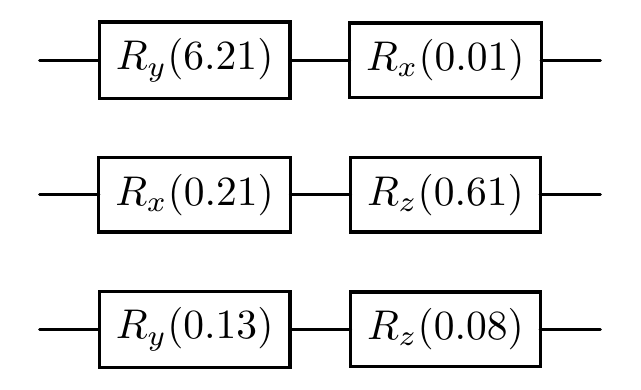

The quantum circuit after removing gates is:


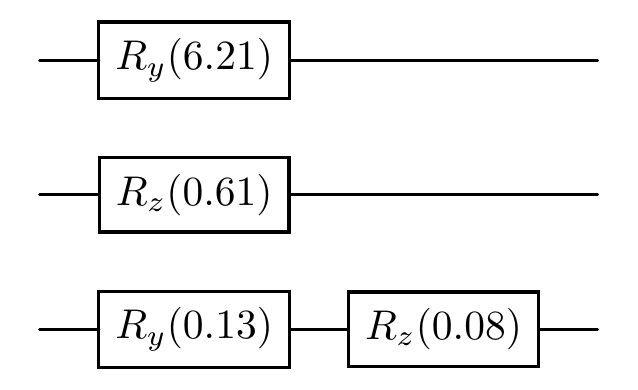

In [15]:
cir = Circuit(num_qubits=3)

# Set parameters and customize quantum gates. Here we select Ry, Rx, Rz gates
param = np.random.rand(2)

# By default, randomly generates a set of parameters
rz_gate = RZ(param=param, qubits_idx=[1, 2])

# Add quantum gates
cir.ry([0, 2])
cir.rx([0, 1])
cir.insert(index=2, module=rz_gate)  # index where to insert

print("The quantum circuit after adding gates is: ")
cir.plot()

cir.pop(1)  # Remove Rx gate
print("The quantum circuit after removing gates is:")
cir.plot()

### Circuit execution

The `Circuit` object can be executed by calling the object itself, and you can apply the circuit to a specific initial state.

In [16]:
output_state = cir()  # Run the circuit with initial state |0>
print("the output state for inputting zero state is:", output_state)

rho = random_state(num_qubits=3)
output_state = cir(rho)  # Run the circuit with initial state sigma
print("the output state for inputting state rho is:", output_state)

the output state for inputting zero state is: 
-----------------------------------------------------
 Backend: default-pure
 System dimension: [2, 2, 2]
 System sequence: [1, 2, 0]
[-0.94+0.34j  0.03-0.01j -0.06+0.02j  0.  -0.j    0.  +0.j    0.  +0.j
  0.  +0.j    0.  +0.j  ]
-----------------------------------------------------

the output state for inputting state rho is: 
-----------------------------------------------------
 Backend: default-mixed
 System dimension: [2, 2, 2]
 System sequence: [1, 2, 0]
[[ 0.27+0.j    0.09+0.03j  0.02-0.04j  0.05-0.03j  0.01-0.01j -0.04-0.02j
   0.01-0.j    0.03-0.1j ]
 [ 0.09-0.03j  0.16+0.j    0.  +0.03j  0.01-0.1j  -0.  -0.01j -0.02+0.04j
  -0.02+0.j   -0.01-0.08j]
 [ 0.02+0.04j  0.  -0.03j  0.12+0.j    0.02-0.j    0.02-0.01j  0.01+0.01j
   0.03-0.j    0.03-0.01j]
 [ 0.05+0.03j  0.01+0.1j   0.02+0.j    0.16+0.j    0.  -0.02j -0.02-0.02j
  -0.02-0.08j  0.08-0.04j]
 [ 0.01+0.01j -0.  +0.01j  0.02+0.01j  0.  +0.02j  0.01+0.j   -0.01+0.j
   0.02+0.

## Other properties

`Circuit` Class has other properties for further information and manipulation. For example, it includes properties like `depth`, `operator_history`, `matrix` and so on.

In [17]:
cir

Circuit(
  (0): RY()
  (1): RZ()
)

In [18]:
print("the circuit depth is", cir.depth, "\n")

print("the gate history of the circuit is\n", cir.operator_history)

the circuit depth is 2 

the gate history of the circuit is
 [{'uid': '2c5a6d60-8b7e-48e6-91e8-136e16ddade0', 'name': 'ry', 'type': 'gate', 'tex': 'R_{y}', 'api': 'ry', 'param_sharing': False, 'plot_width': 0.9, 'system_idx': [[0], [2]], 'param': Parameter containing:
tensor([[[6.2116]],

        [[0.1307]]], requires_grad=True), 'matrix': tensor([[[-0.9994+0.j, -0.0358+0.j],
         [ 0.0358+0.j, -0.9994+0.j]],

        [[ 0.9979+0.j, -0.0653+0.j],
         [ 0.0653+0.j,  0.9979+0.j]]], grad_fn=<SqueezeBackward0>)}, {'uid': '13ab35a0-14c9-4c4c-ac19-c287d792fb1c', 'name': 'rz', 'type': 'gate', 'tex': 'R_{z}', 'api': 'rz', 'param_sharing': False, 'plot_width': 0.9, 'system_idx': [[1], [2]], 'param': tensor([[[0.6094]],

        [[0.0777]]]), 'matrix': tensor([[[0.9539-0.3000j, 0.0000+0.0000j],
         [0.0000+0.0000j, 0.9539+0.3000j]],

        [[0.9992-0.0388j, 0.0000+0.0000j],
         [0.0000+0.0000j, 0.9992+0.0388j]]])}]


Additionally, one can update the parameters of parameterized gates (if they exist) using the `update_param` method.

In [19]:
print("the trainable parameters of entire circuit are", cir.param)

cir.update_param(torch.ones_like(cir.param))  # update the parameters of the circuit
print("the updated trainable parameters of entire circuit are", cir.param)

the trainable parameters of entire circuit are tensor([6.2116, 0.1307])
the updated trainable parameters of entire circuit are tensor([1., 1.])


It is worth noting that `Circuit` is inherently a subclass of `torch.Module`, implying that variational quantum circuit can be used as a part of the neural network model in PyTorch.

---

## References

[1] Nielsen, Michael A., and Isaac L. Chuang. *Quantum computation and quantum information*. Cambridge university press, 2010.

*Table: A reference of notation conventions in this tutorial.*

| Symbol        | Variant          | Description                               |
|:---------------:|:------------------:|-------------------------------------------|
|$U$| |unitary matrix|
|$\text{CNOT}$| |controlled-NOT gate|
|$X$| |Pauli X gate|
|$H$| |Hadamard gate|
|$R_{x/y/z}$| $R_{x/y/z}(\theta)$ | rotation wrt. the axis of $X$/$Y$/$Z$ (with angle $\theta$)|
|$I$| $I_{2}$ | ($2\times 2$) identity matrix|
|$\text{QFT}$| $\text{QFT}_n$ | ($n$-qubit) quantum Fourier transformation matrix|

In [20]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.1
torch: 2.8.0+cu128
torch cuda: 12.8
numpy: 2.2.6
scipy: 1.15.3
matplotlib: 3.10.5
---------SYSTEM---------
Python version: 3.10.18
OS: Linux
OS version: #1 SMP Tue Nov 5 00:21:55 UTC 2024
---------DEVICE---------
CPU:  13th Gen Intel(R) Core(TM) i9-13980HX
GPU: (0) NVIDIA GeForce RTX 4090 Laptop GPU
